In [1]:
import os 
import pandas as pd 
import numpy as np
import torch
from dfencoder import AutoEncoder
from pathlib import Path
import json
from sklearn.model_selection import train_test_split
import matplotlib
from matplotlib import pyplot as plt 

Big Picture: 
- For the dfp pipeline (Training)
    - Preproc
    - dfp_rolling_window
    - data prep
    - monitor module 
    - dfp training module
    



In [2]:
def load_data(train_data_dir: Path):
    i = 0 
    all_data_dfs = []
    for a_td in train_data_dir.iterdir():
        with open(a_td,'r') as f: 
            json_obj = json.load(f)
        json_normalized = pd.json_normalize(json_obj)
        all_data_dfs.append(json_normalized)
    return all_data_dfs

In [3]:
azure_training_data = Path("data/azure-training-data")
azure_inference_data = Path("data/azure-inference-data")

In [4]:
azure_training_data_df_list = load_data(azure_training_data)
azure_inference_data_df_list = load_data(azure_inference_data)
#azure_training_data_df = pd.DataFrame(azure_training_data_json)
#azure_inference_data_df = pd.DataFrame(azure_inference_data_json)

In [5]:
# concat into one big dataframe for training and inference 

azure_training_df = pd.concat(azure_training_data_df_list)
azure_inference_df = pd.concat(azure_inference_data_df_list)


In [6]:
azure_training_df['properties.userDisplayName'].unique()

array(['Thomas Price', 'Attack Target', 'Aaron Cole', 'Joseph Taylor',
       'Cynthia Perry', 'Alicia Ramirez', 'Jim Gonzalez',
       'Cassie Fernandez', 'Jacob Meyers', 'Nicholas Black',
       'Terry Proctor', 'Vanessa Ramirez', 'Keith Sheppard',
       'Jamie Watson', 'Kristen Howell', 'David Johnson',
       'Melissa Martin', 'Amy Anderson', 'Angela Kerr', 'Robert Rojas'],
      dtype=object)

In [7]:
tp_train_df = azure_training_df[azure_training_df['properties.userDisplayName'] == 'Thomas Price']
tp_train_df

,time,resourceId,operationName,operationVersion,category,tenantId,resultType,resultSignature,resultDescription,durationMs,...,properties.authenticationProtocol,properties.appServicePrincipalId,properties.resourceServicePrincipalId,properties.rngcStatus,properties.ipAddressFromResourceProvider,properties.status.additionalDetails,properties.deviceDetail.isCompliant,properties.deviceDetail.isManaged,properties.alternateSignInName,properties.signInIdentifier
0,2022-08-02T18:07:04.839189Z,/tenants/d3e5a967-5657-4a42-afcc-6106b6c3c299/...,Sign-in activity,1.0,NonInteractiveUserSignInLogs,d3e5a967-5657-4a42-afcc-6106b6c3c299,50158,None,External security challenge was not satisfied.,0,...,none,None,15655e1f-5005-4c53-b3c0-c4a1d1ca5e9e,0.0,NaN,NaN,NaN,NaN,NaN,NaN
10,2022-08-02T20:04:24.740792Z,/tenants/d3e5a967-5657-4a42-afcc-6106b6c3c299/...,Sign-in activity,1.0,NonInteractiveUserSignInLogs,d3e5a967-5657-4a42-afcc-6106b6c3c299,50158,None,External security challenge was not satisfied.,0,...,none,None,a6c259e5-7f16-48b2-a9f3-75becd6daa9b,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,2022-08-02T20:49:14.545846Z,/tenants/d3e5a967-5657-4a42-afcc-6106b6c3c299/...,Sign-in activity,1.0,NonInteractiveUserSignInLogs,d3e5a967-5657-4a42-afcc-6106b6c3c299,50158,None,External security challenge was not satisfied.,0,...,none,None,a6c259e5-7f16-48b2-a9f3-75becd6daa9b,0.0,NaN,NaN,NaN,NaN,NaN,NaN
13,2022-08-02T20:57:20.054843Z,/tenants/d3e5a967-5657-4a42-afcc-6106b6c3c299/...,Sign-in activity,1.0,NonInteractiveUserSignInLogs,d3e5a967-5657-4a42-afcc-6106b6c3c299,0,None,None,0,...,none,None,0eae9886-2d60-475f-9a14-3151a1cfa557,0.0,NaN,NaN,True,True,NaN,NaN
3,2022-08-08T07:31:03.756825Z,/tenants/d3e5a967-5657-4a42-afcc-6106b6c3c299/...,Sign-in activity,1.0,NonInteractiveUserSignInLogs,d3e5a967-5657-4a42-afcc-6106b6c3c299,50158,None,External security challenge was not satisfied.,0,...,none,None,15655e1f-5005-4c53-b3c0-c4a1d1ca5e9e,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2022-08-16T02:04:57.412611Z,/tenants/d3e5a967-5657-4a42-afcc-6106b6c3c299/...,Sign-in activity,1.0,NonInteractiveUserSignInLogs,d3e5a967-5657-4a42-afcc-6106b6c3c299,50158,None,External security challenge was not satisfied.,0,...,none,None,a6c259e5-7f16-48b2-a9f3-75becd6daa9b,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2022-08-16T02:16:45.198669Z,/tenants/d3e5a967-5657-4a42-afcc-6106b6c3c299/...,Sign-in activity,1.0,NonInteractiveUserSignInLogs,d3e5a967-5657-4a42-afcc-6106b6c3c299,50158,None,External security challenge was not satisfied.,0,...,none,None,a6c259e5-7f16-48b2-a9f3-75becd6daa9b,0.0,NaN,NaN,NaN,NaN,NaN,NaN
8,2022-08-16T02:46:31.318879Z,/tenants/d3e5a967-5657-4a42-afcc-6106b6c3c299/...,Sign-in activity,1.0,NonInteractiveUserSignInLogs,d3e5a967-5657-4a42-afcc-6106b6c3c299,50158,None,External security challenge was not satisfied.,0,...,none,None,a6c259e5-7f16-48b2-a9f3-75becd6daa9b,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2022-08-20T12:02:07.076464Z,/tenants/d3e5a967-5657-4a42-afcc-6106b6c3c299/...,Sign-in activity,1.0,NonInteractiveUserSignInLogs,d3e5a967-5657-4a42-afcc-6106b6c3c299,50158,None,External security challenge was not satisfied.,0,...,none,None,15655e1f-5005-4c53-b3c0-c4a1d1ca5e9e,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# split dataframe into user specific dfs
unique_names = list(azure_training_df['properties.userDisplayName'].unique())
training_data_dfs = {}
inference_data_dfs = {}
for name in unique_names: 
    name_azure_training_df = azure_training_df[azure_training_df['properties.userDisplayName'] == name]
    name_azure_inf_df = azure_inference_df[azure_inference_df['properties.userDisplayName'] == name]
    
    training_data_dfs[name] = name_azure_training_df
    inference_data_dfs[name] = name_azure_inf_df

In [9]:
for name, df in training_data_dfs.items(): 
    print('Name=', name)
    print('Training samples:', len(df))
    print('Inference samples', len(inference_data_dfs[name]))

Name= Thomas Price
Training samples: 493
Inference samples 32
Name= Attack Target
Training samples: 378
Inference samples 124
Name= Aaron Cole
Training samples: 371
Inference samples 28
Name= Joseph Taylor
Training samples: 300
Inference samples 19
Name= Cynthia Perry
Training samples: 424
Inference samples 26
Name= Alicia Ramirez
Training samples: 11
Inference samples 0
Name= Jim Gonzalez
Training samples: 122
Inference samples 8
Name= Cassie Fernandez
Training samples: 126
Inference samples 12
Name= Jacob Meyers
Training samples: 123
Inference samples 8
Name= Nicholas Black
Training samples: 10
Inference samples 1
Name= Terry Proctor
Training samples: 124
Inference samples 5
Name= Vanessa Ramirez
Training samples: 130
Inference samples 5
Name= Keith Sheppard
Training samples: 117
Inference samples 13
Name= Jamie Watson
Training samples: 119
Inference samples 12
Name= Kristen Howell
Training samples: 120
Inference samples 10
Name= David Johnson
Training samples: 122
Inference samples 

Feature Preprocessing

In [10]:
# feature_list_p = [
#     'appDisplayName',
#     'clientAppUsed',
#     'deviceDetail.displayName',
#     'deviceDetail.browser',
#     'deviceDetail.operatingSystem',
#     'statusFailureReason',
#     'riskEventTypes_v2',
#     'location.countryOrRegion',
#     'location.city',
# ]

feature_list_p = [
    'appDisplayName',
    'clientAppUsed',
    'deviceDetail.displayName',
    'deviceDetail.browser',
    'deviceDetail.operatingSystem',
    'status.failureReason',
    'location.countryOrRegion',
    'location.city',
]


# TODO: experiment - add timestamp, then what ? 

In [11]:
cols = azure_training_df.columns
for p in feature_list_p: 
    for c in cols: 
        if p in c: 
            print(c)

properties.appDisplayName
properties.clientAppUsed
properties.deviceDetail.displayName
properties.deviceDetail.browser
properties.deviceDetail.operatingSystem
properties.status.failureReason
properties.location.countryOrRegion
properties.location.city


In [12]:
feature_list = [('properties.' + f) for f in feature_list_p]

In [13]:
feature_list

['properties.appDisplayName',
 'properties.clientAppUsed',
 'properties.deviceDetail.displayName',
 'properties.deviceDetail.browser',
 'properties.deviceDetail.operatingSystem',
 'properties.status.failureReason',
 'properties.location.countryOrRegion',
 'properties.location.city']

In [14]:
for c in azure_training_df.columns:
    if 'riskEventTypesv2' in c: 
        print(c)

In [15]:
def convert_column_names(df):
    df.columns = [col.replace(".","_") for col in df.columns]
    return df     

In [16]:
feat_processed_training_data_dfs = {}
feat_processed_inference_data_dfs = {}

for name, train_df in training_data_dfs.items():
    feat_proc_train_df = train_df[feature_list]
    #feat_proc_train_df = feat_proc_train_df.drop('properties.deviceDetail.displayName',axis=1)
    feat_proc_train_df = convert_column_names(feat_proc_train_df)
    feat_processed_training_data_dfs[name] = feat_proc_train_df

for name, inf_df in inference_data_dfs.items():
    feat_proc_inf_df = inf_df[feature_list]
    feat_proc_inf_df = convert_column_names(feat_proc_inf_df)
    feat_processed_inference_data_dfs[name] = feat_proc_inf_df




In [17]:
tp_df = feat_processed_training_data_dfs['Thomas Price']
tp_df

,properties_appDisplayName,properties_clientAppUsed,properties_deviceDetail_displayName,properties_deviceDetail_browser,properties_deviceDetail_operatingSystem,properties_status_failureReason,properties_location_countryOrRegion,properties_location_city
0,Cisco AnyConnect,Mobile Apps and Desktop clients,THOMASPRICE-LT,Edge 118.12158,Windows 10,External security challenge was not satisfied.,XQ,Brownton
10,Adobe Identity Management,Mobile Apps and Desktop clients,THOMASPRICE-LT,Edge 118.12158,Windows 10,External security challenge was not satisfied.,XR,Port Denisetown
12,Adobe Identity Management,Mobile Apps and Desktop clients,THOMASPRICE-LT,Edge 118.12158,Windows 10,External security challenge was not satisfied.,XN,Littlemouth
13,Adoddle cSaas Platform,Mobile Apps and Desktop clients,THOMASPRICE-LT,Edge 40.11325,Windows 10,NaN,XQ,Francoshire
3,Cisco AnyConnect,Mobile Apps and Desktop clients,THOMASPRICE-LT,Edge 118.12158,Windows 10,External security challenge was not satisfied.,XR,Kevinton
...,...,...,...,...,...,...,...,...
4,Adobe Identity Management,Mobile Apps and Desktop clients,THOMASPRICE-LT,Edge 118.12158,Windows 10,External security challenge was not satisfied.,XR,Port Denisetown
6,Adobe Identity Management,Mobile Apps and Desktop clients,THOMASPRICE-LT,Edge 118.12158,Windows 10,External security challenge was not satisfied.,XR,Port Denisetown
8,Adobe Identity Management,Mobile Apps and Desktop clients,THOMASPRICE-LT,Edge 118.12158,Windows 10,External security challenge was not satisfied.,XN,Littlemouth
0,Cisco AnyConnect,Mobile Apps and Desktop clients,THOMASPRICE-LT,Edge 118.12158,Windows 10,External security challenge was not satisfied.,XR,Kevinton


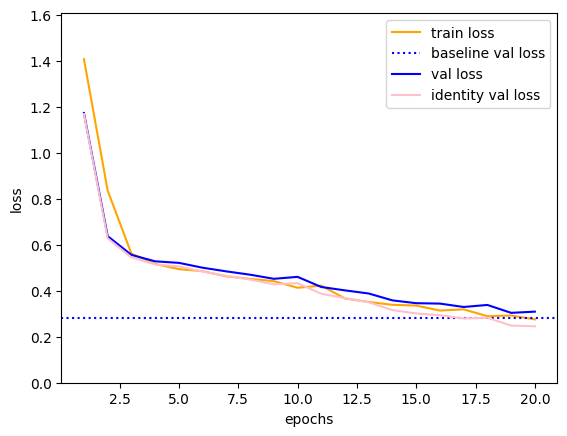

In [18]:
# user_models_by_name = {}
# for name, df in feat_processed_training_data_dfs.items():
#     model = train_user_model(df)
#     user_models_by_name[name] = model

mps_device = torch.device("mps:0")


split_size = 0.2

train_df, val_df = train_test_split(tp_df, test_size=split_size)

num_columns = len(tp_df.columns) 
model = AutoEncoder(encoder_layers=[512,510], # try [512,510]
                    decoder_layers=[512],                    # [512]
                    activation='relu',
                    swap_p=0.2,
                    lr=0.01,
                    batch_size=32,
                    optimizer='sgd',
                    scaler='gauss_rank',
                    logger='ipynb',
                    min_cats=1)

model.fit(train_df,20,val_df)




In [19]:
def inference(model,df):
    anomaly_scores = model.get_anomaly_score(df)
    return anomaly_scores

In [20]:
# implement digital fingerprinting code / implement the actual pipeline
# feat_processed_inference_data_dfs
# for name, df  in feat_processed_inference_data_dfs: 
#     model = user_models_by_name[name]
#     anomaly_scores =
    

In [21]:
tp_inf_data = feat_processed_inference_data_dfs['Thomas Price']

In [22]:

ae_anomaly_score = model.get_anomaly_score(tp_inf_data)
tp_inf_data['anomaly_score'] = ae_anomaly_score


/var/folders/zc/6mjfb52x73qf5c6y554p68l40000gn/T/ipykernel_41545/2594378420.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp_inf_data['anomaly_score'] = ae_anomaly_score


In [23]:
tp_inf_data

,properties_appDisplayName,properties_clientAppUsed,properties_deviceDetail_displayName,properties_deviceDetail_browser,properties_deviceDetail_operatingSystem,properties_status_failureReason,properties_location_countryOrRegion,properties_location_city,anomaly_score
3,Adobe Identity Management,Mobile Apps and Desktop clients,THOMASPRICE-LT,Edge 118.12158,Windows 10,External security challenge was not satisfied.,XQ,Brownton,0.500647
6,Adobe Identity Management,Mobile Apps and Desktop clients,THOMASPRICE-LT,Edge 118.12158,Windows 10,External security challenge was not satisfied.,XR,Port Denisetown,0.027537
9,Adobe Identity Management,Mobile Apps and Desktop clients,THOMASPRICE-LT,Edge 118.12158,Windows 10,Other,XR,Port Kimberlytown,0.256753
17,Cisco AnyConnect,Mobile Apps and Desktop clients,THOMASPRICE-LT,Edge 118.12158,Windows 10,External security challenge was not satisfied.,XN,Littlemouth,0.098955
10,Cisco AnyConnect,Mobile Apps and Desktop clients,THOMASPRICE-LT,Edge 118.12158,Windows 10,External security challenge was not satisfied.,XQ,Brownton,0.510022
15,Cisco AnyConnect,Mobile Apps and Desktop clients,THOMASPRICE-LT,Edge 118.12158,Windows 10,External security challenge was not satisfied.,XR,Santosborough,0.176262
0,Adobe Identity Management,Mobile Apps and Desktop clients,THOMASPRICE-LT,Edge 118.12158,Windows 10,External security challenge was not satisfied.,XN,Littlemouth,0.078602
2,Adobe Identity Management,Mobile Apps and Desktop clients,THOMASPRICE-LT,Edge 118.12158,Windows 10,External security challenge was not satisfied.,XN,Littlemouth,0.078602
6,Adobe Identity Management,Mobile Apps and Desktop clients,THOMASPRICE-LT,Edge 118.12158,Windows 10,External security challenge was not satisfied.,XR,Port Denisetown,0.027537
19,Adobe Identity Management,Mobile Apps and Desktop clients,THOMASPRICE-LT,Edge 118.12158,Windows 10,External security challenge was not satisfied.,XR,Santosborough,0.227882


In [24]:
tp_inf_data.sort_values('anomaly_score',ascending=False).head(10)
tp_inf_data["zscore"] = (tp_inf_data["anomaly_score"] - tp_inf_data["anomaly_score"].mean())/tp_inf_data["anomaly_score"].std()


/var/folders/zc/6mjfb52x73qf5c6y554p68l40000gn/T/ipykernel_41545/2706626964.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp_inf_data["zscore"] = (tp_inf_data["anomaly_score"] - tp_inf_data["anomaly_score"].mean())/tp_inf_data["anomaly_score"].std()


In [25]:
# anomalous events 

tp_inf_data[tp_inf_data['zscore']> 2]

,properties_appDisplayName,properties_clientAppUsed,properties_deviceDetail_displayName,properties_deviceDetail_browser,properties_deviceDetail_operatingSystem,properties_status_failureReason,properties_location_countryOrRegion,properties_location_city,anomaly_score,zscore
17,SD ECDN,Browser,THOMASPRICE-LT,Rich Client 3.19.8.16603,Windows 10,NaN,XQ,Veronicachester,1.393334,3.496923
18,Bipsync,Mobile Apps and Desktop clients,NaN,NaN,Android,NaN,XQ,Herringburgh,1.221350,2.982029


In [26]:
# next set of EXPERIMENTS:  
# extend with : 
# location / doctor it , i.e. mycustomlocation , does this get picked up by the algorithm. 
# timestamp / same thing as above 
# IP address / same thing as above 

In [ ]:
# understand this enough to be able to ask questions tomo 

In [ ]:
# TASKS for next week 
# apply above pipeline to Cloud UEBA dataset 
# the other dataset need link 